<a href="https://colab.research.google.com/github/ethangearey/nc-lora/blob/main/Experiment_1%2B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 1+2: Tracking Neural Collapse and Feature Rank (1); Measuring Parameter Update Rank (2)

## Experiment 1
Train deep networks (e.g., ResNet18 on CIFAR-10) with cross-entropy loss.
At each epoch, compute:
- NC metrics (Papyan et al.): NC1-NC4
- Rank of penultimate-layer feature matrix
- Spectrum of singular values (SVD) of class means and classwise features

Goal: empirically track the onset and strength of neural collapse vs. feature-space dimensionality.

## Experiment 2
- Save weight updates over training (e.g., via finite differences or gradients).
- Measure their empirical rank and SVD spectrum.
- Check if late-stage training updates concentrate into a low-rank subspace, coinciding with the emergence of NC.

Goal: evaluate whether global parameter (weight) updates show low-rank at the same time as neural collapse. Ensure that the low-rank parameter updates occur in the classifier and the layer before.







NOTE: Checkpointing only works for Experiment 1 (tracker object not included in checkpoint for storage reasons)


Todo:
1. Dry runs with new figs
  - validate they're what you want?
2. Memory concerns with UpdateTracker
  - "Memory is a genuine concern for long runs. Proactive optimization is critical to avoid crashes."
  - incrementalPCA?
  - float16?



In [76]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
overwrite_checkpoint = True

import gc
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from tqdm import tqdm
from collections import OrderedDict
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd
from torchvision import datasets, transforms
from IPython import embed
from sklearn.decomposition import IncrementalPCA

debug = True # Only runs 20 batches per epoch for debugging

# Random seed
seed                = 42
torch.manual_seed(seed)
np.random.seed(seed)

# CIFAR dataset parameters
im_size             = 32
padded_im_size      = 32
input_ch            = 3
C                   = 10

# Optimization Criterion
loss_name = 'CrossEntropyLoss'

# Optimization hyperparameters
lr_decay            = 0.1
lr                  = 0.1 # modify?

epochs              = 350
epochs_lr_decay     = [epochs//3, epochs*2//3]

batch_size          = 128

momentum            = 0.9
weight_decay        = 5e-4

# analysis parameters
RANK_THRESHOLD      = 0.99
tracked_layers      = ['fc.weight', 'layer4.1.conv2.weight']

epoch_list          = [1,   2,    4,   5,   6,   7,   8,   9,   10,   11,
                       12,  13,  14,  16,  17,  19,  20,  22,  24,  27,   29,
                       32,  35,  38,  42,  45,  50,  54,  59,  65,  71,   77,
                       85,  92,  101, 110, 121, 132, 144, 158, 172, 188,  206,
                       225, 245, 268, 293, 320, 340, 341, 342, 343, 344, 345,
                       346, 347, 348, 349, 350]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
def train(model, criterion, device, num_classes, train_loader, optimizer, epoch):
    model.train()

    pbar = tqdm(total=len(train_loader), position=0, leave=True)
    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        if data.shape[0] != batch_size:
            continue

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        if str(criterion) == 'CrossEntropyLoss()':
          loss = criterion(out, target)

        loss.backward()
        optimizer.step()

        accuracy = torch.mean((torch.argmax(out,dim=1)==target).float()).item()

        pbar.update(1)
        pbar.set_description(
            'Train\t\tEpoch: {} [{}/{} ({:.0f}%)] \t'
            'Batch Loss: {:.6f} \t'
            'Batch Accuracy: {:.6f}'.format(
                epoch,
                batch_idx,
                len(train_loader),
                100. * batch_idx / len(train_loader),
                loss.item(),
                accuracy))

        if debug and batch_idx > 20:
          break
    pbar.close()

In [78]:
def analysis(graphs, model, criterion_summed, device, num_classes, loader):
    model.eval()

    N             = [0 for _ in range(C)]
    mean          = [0 for _ in range(C)]
    Sw            = 0

    all_features = []
    class_features = [[] for _ in range(C)]

    loss          = 0
    net_correct   = 0
    NCC_match_net = 0

    for computation in ['Mean','Metrics']:
        pbar = tqdm(total=len(loader), position=0, leave=True)
        for batch_idx, (data, target) in enumerate(loader, start=1):

            data, target = data.to(device), target.to(device)
            output = model(data)

            h = features.value.data.view(data.shape[0],-1) # B CHW

            # Collect all features for rank analysis
            if computation == 'Mean':
              all_features.append(h.cpu().detach())

            # during calculation of class means, calculate loss
            if computation == 'Mean':
                if str(criterion_summed) == 'CrossEntropyLoss()':
                  loss += criterion_summed(output, target).item()

            for c in range(C):
                # features belonging to class c
                idxs = (target == c).nonzero(as_tuple=True)[0]

                if len(idxs) == 0: # If no class-c in this batch
                  continue

                h_c = h[idxs,:] # B CHW

                # Collect class-specific features for SVD analysis
                if computation == 'Mean':
                  class_features[c].append(h_c.cpu().detach())

                if computation == 'Mean':
                    # update class means
                    mean[c] += torch.sum(h_c, dim=0) # CHW
                    N[c] += h_c.shape[0]

                elif computation == 'Metrics':
                    ## COV
                    # update within-class cov
                    z = h_c - mean[c].unsqueeze(0) # B CHW
                    cov = torch.matmul(z.unsqueeze(-1), # B CHW 1
                                       z.unsqueeze(1))  # B 1 CHW
                    Sw += torch.sum(cov, dim=0)

                    # during calculation of within-class covariance, calculate:
                    # 1) network's accuracy
                    net_pred = torch.argmax(output[idxs,:], dim=1)
                    net_correct += sum(net_pred==target[idxs]).item()

                    # 2) agreement between prediction and nearest class center
                    NCC_scores = torch.stack([torch.norm(h_c[i,:] - M.T,dim=1) \
                                              for i in range(h_c.shape[0])])
                    NCC_pred = torch.argmin(NCC_scores, dim=1)
                    NCC_match_net += sum(NCC_pred==net_pred).item()

            pbar.update(1)
            pbar.set_description(
                'Analysis {}\t'
                'Epoch: {} [{}/{} ({:.0f}%)]'.format(
                    computation,
                    epoch,
                    batch_idx,
                    len(loader),
                    100. * batch_idx/ len(loader)))

            if debug and batch_idx > 20:
                break
        pbar.close()

        if computation == 'Mean':
            for c in range(C):
                mean[c] /= N[c]
                M = torch.stack(mean).T
            loss /= sum(N)

            # Feature rank analysis
            all_features_tensor = torch.cat(all_features, dim=0)

            # Compute feature rank using *randomized* SVD
            U, S, _ = randomized_svd(all_features_tensor.cpu().numpy(), n_components=100)
            S = torch.from_numpy(S).to(device)

            # Calculate effective rank
            normalized_sv = S / torch.sum(S)
            cumulative_energy = torch.cumsum(normalized_sv, dim=0)
            effective_rank = torch.sum(cumulative_energy < 0.99) + 1 # so 99% is the threshold?

            graphs.feature_rank.append(effective_rank.item())
            graphs.singular_values.append(S.cpu().numpy())

            # Class means SVD
            U_M, S_M, V_M = torch.svd(M, some=True)
            graphs.mean_singular_values.append(S_M.cpu().numpy())

            # Class-wise SVD analysis
            class_sv_lists = []
            for c in range(C):
                if len(class_features[c]) > 0:
                    class_feat = torch.cat(class_features[c], dim=0)
                    # Center the features
                    class_feat = class_feat - mean[c].unsqueeze(0)
                    # Compute SVD
                    try:
                        _, S_c, _ = torch.svd(class_feat, some=True)
                        class_sv_lists.append(S_c.cpu().numpy())
                    except:
                        # Handle potential numerical issues
                        class_sv_lists.append(np.zeros(min(class_feat.shape)))

            graphs.class_singular_values.append(class_sv_lists)
        elif computation == 'Metrics':
            Sw /= sum(N)

    graphs.loss.append(loss)
    graphs.accuracy.append(net_correct/sum(N))
    graphs.NCC_mismatch.append(1-NCC_match_net/sum(N))

    # loss with weight decay
    reg_loss = loss
    for param in model.parameters():
        reg_loss += 0.5 * weight_decay * torch.sum(param**2).item()
    graphs.reg_loss.append(reg_loss)

    # global mean
    muG = torch.mean(M, dim=1, keepdim=True) # CHW 1

    # between-class covariance
    M_ = M - muG
    Sb = torch.matmul(M_, M_.T) / C

    # avg norm
    W  = classifier.weight
    M_norms = torch.norm(M_,  dim=0)
    W_norms = torch.norm(W.T, dim=0)

    graphs.norm_M_CoV.append((torch.std(M_norms)/torch.mean(M_norms)).item())
    graphs.norm_W_CoV.append((torch.std(W_norms)/torch.mean(W_norms)).item())

    # tr{Sw Sb^-1}
    Sw = Sw.cpu().double()
    Sw += 1e-8 * torch.eye(Sw.shape[0], device=Sw.device) # add jitter for numerical sability
    Sb = Sb.cpu().double()  # Extra precision for small eigenvalues; modified orig.
    eigvec, eigval, _ = torch.svd_lowrank(Sb, q=C-1)
    inv_Sb = eigvec @ torch.diag(1/eigval) @ eigvec.T
    graphs.Sw_invSb.append(torch.trace(Sw @ inv_Sb).item())

    # ||W^T - M_||
    normalized_M = M_ / torch.norm(M_,'fro')
    normalized_W = W.T / torch.norm(W.T,'fro')
    graphs.W_M_dist.append((torch.norm(normalized_W - normalized_M)**2).item())

    # mutual coherence
    def coherence(V):
        G = V.T @ V
        G += torch.ones((C,C),device=device) / (C-1)
        G -= torch.diag(torch.diag(G))
        return torch.norm(G,1).item() / (C*(C-1))

    graphs.cos_M.append(coherence(M_/M_norms))
    graphs.cos_W.append(coherence(W.T/W_norms))


In [79]:
class UpdateTracker:
    def __init__(self, model):
        # global tracking
        self.prev_weights = {n: p.detach().clone() for n, p in model.named_parameters()}
        self.deltas = []  # Stores each epoch's delta as a row
        self.effective_ranks = []
        self.singular_values = []

        # layer-specific tracking
        self.tracked_layers = tracked_layers
        self.layer_prev_weights = {n: p.detach().clone() for n, p in model.named_parameters() if n in self.tracked_layers}
        self.layer_deltas = {n: [] for n in self.tracked_layers}
        self.layer_effective_ranks = {n: [] for n in self.tracked_layers}
        self.layer_singular_values = {n: [] for n in self.tracked_layers}

    def compute_update_rank(self, model):
        # Compute delta for all parameters
        delta = []
        for n, p in model.named_parameters():
            delta.append((p.detach() - self.prev_weights[n]).flatten().cpu().numpy())
        delta_vector = np.concatenate(delta)  # Shape: [total_parameters]

        # Append delta to the list (each row is an epoch's delta)
        self.deltas.append(delta_vector)

        if len(self.deltas) == 0:
            effective_rank = 0
            sv = np.array([])
        else:
            # Stack deltas into a matrix (num_epochs x total_parameters)
            delta_matrix = np.vstack(self.deltas)

            # Compute randomized SVD
            n_components = min(delta_matrix.shape[0], 100)
            if delta_matrix.shape[0] == 0:
                U, S, Vt = np.linalg.svd(delta_matrix, full_matrices=False)
            else:
                U, S, _ = randomized_svd(delta_matrix, n_components=n_components)

            # Calculate effective rank
            explained_variance = np.cumsum(S**2) / np.sum(S**2)
            effective_rank = np.sum(explained_variance < RANK_THRESHOLD) + 1
            self.singular_values.append(S.copy())

        self.effective_ranks.append(effective_rank)

        for layer_name in self.tracked_layers:
            # Compute delta for this layer only
            current_param = model.state_dict()[layer_name]
            prev_param = self.layer_prev_weights[layer_name]
            layer_delta = (current_param - prev_param).flatten().cpu().numpy().astype(np.float16)  # Save memory
            self.layer_deltas[layer_name].append(layer_delta)

            # Compute effective rank for this layer
            if len(self.layer_deltas[layer_name]) > 0:
                delta_matrix_layer = np.vstack(self.layer_deltas[layer_name])
                n_components_layer = min(delta_matrix_layer.shape[0], 100)
                U_layer, S_layer, _ = randomized_svd(delta_matrix_layer, n_components=n_components_layer)
                explained_variance_layer = np.cumsum(S_layer**2) / np.sum(S_layer**2)
                effective_rank_layer = np.sum(explained_variance_layer < RANK_THRESHOLD) + 1
                self.layer_effective_ranks[layer_name].append(effective_rank_layer)
                self.layer_singular_values[layer_name].append(S_layer.copy())


        # Update previous weights
        self.prev_weights = {n: p.detach().clone() for n, p in model.named_parameters()}
        self.layer_prev_weights = {n: model.state_dict()[n].detach().clone() for n in self.tracked_layers}
        return effective_rank


class Graphs:
  def __init__(self):
    self.accuracy     = []
    self.loss         = []
    self.reg_loss     = []

    # NC1
    self.Sw_invSb     = []

    # NC2
    self.norm_M_CoV   = []
    self.norm_W_CoV   = []
    self.cos_M        = []
    self.cos_W        = []

    # NC3
    self.W_M_dist     = []

    # NC4
    self.NCC_mismatch = []

    # Feature rank analysis
    self.feature_rank = []
    self.singular_values = []
    self.mean_singular_values = []
    self.class_singular_values = []

    # Update rank and SVD spectrum
    self.update_ranks = []
    self.update_spectra = []
    self.layer_update_ranks = {'fc.weight': [], 'layer4.1.conv2.weight': []}
    self.layer_singular_values = {'fc.weight': [], 'layer4.1.conv2.weight': []}

    # Decomposition -> redundant?
    self.LNC1 = []
    self.LNC23 = []
    self.Lperp = []



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Train		Epoch: 1 [21/390 (5%)] 	Batch Loss: 2.496814 	Batch Accuracy: 0.148438:   5%|▌         | 21/390 [04:00<1:10:20, 11.44s/it]
Analysis Metrics	Epoch: 1 [21/390 (5%)]:   5%|▌         | 21/390 [01:10<20:43,  3.37s/it]
<ipython-input-80-9312f4dadc51>:196: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-80-9312f4dadc51>:208: UserWarning:

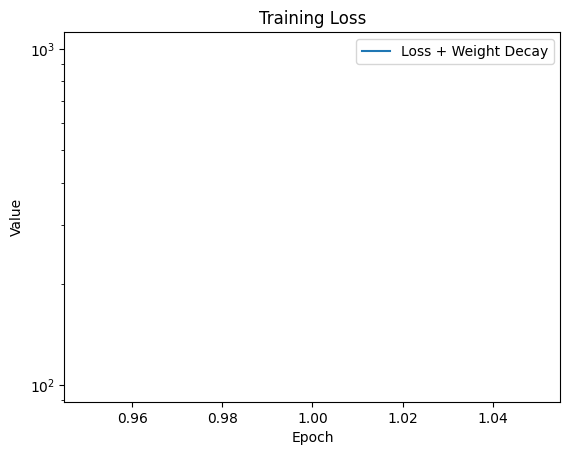

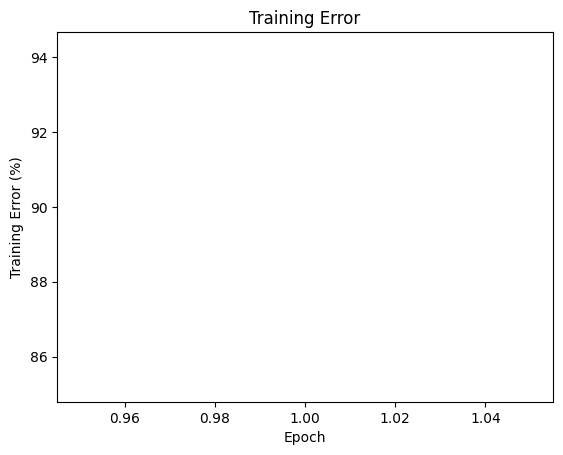

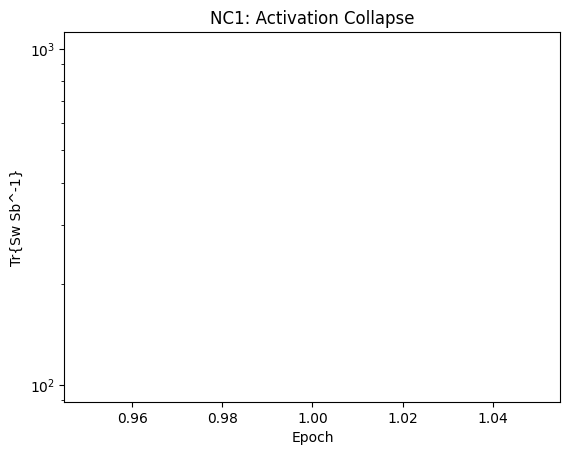

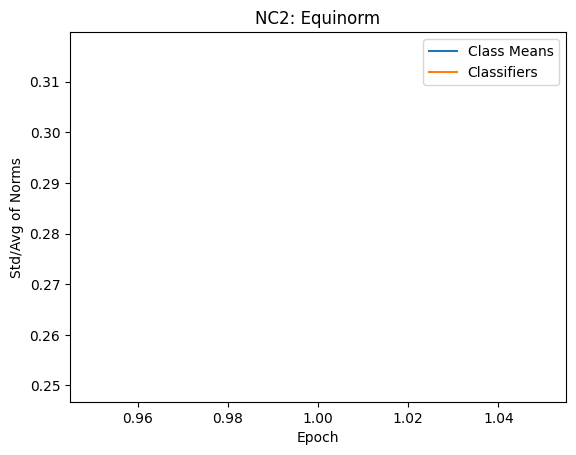

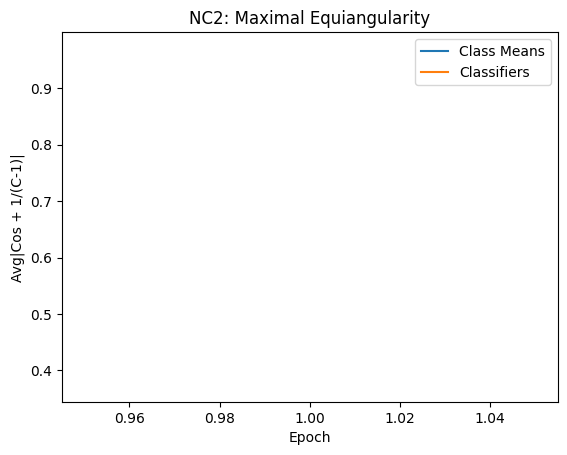

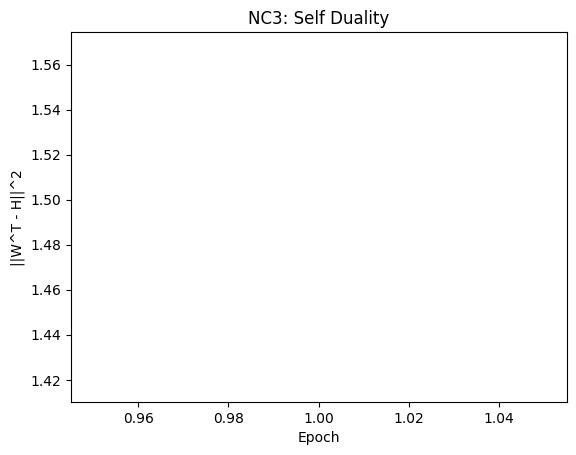

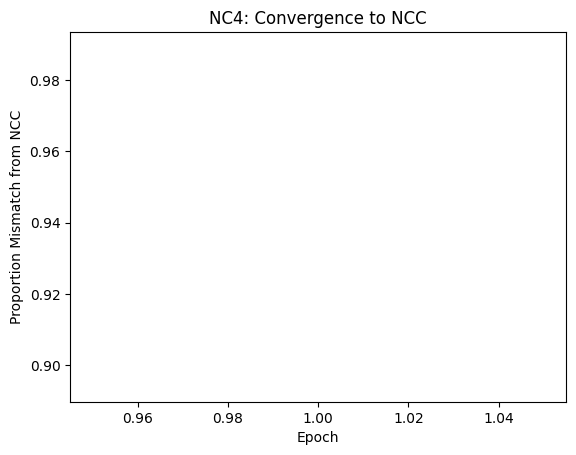

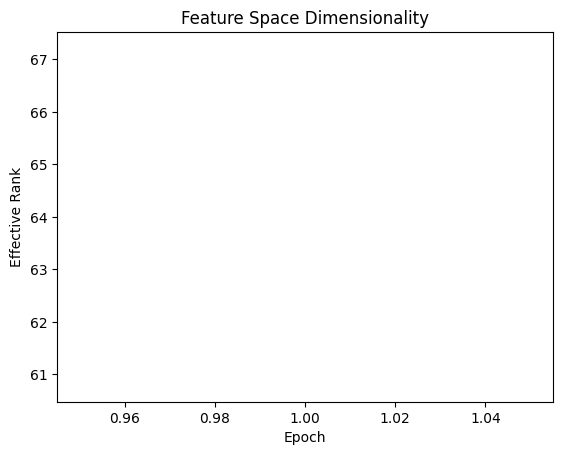

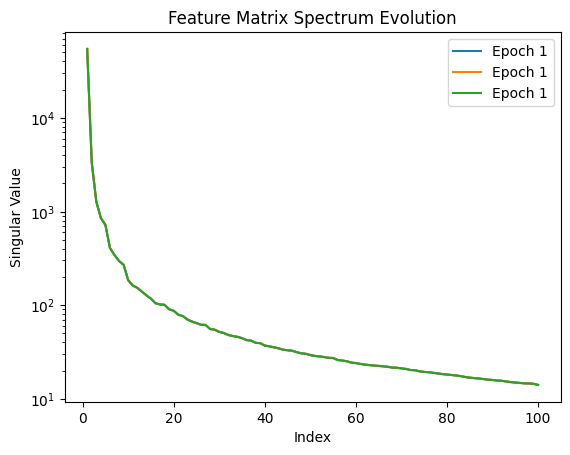

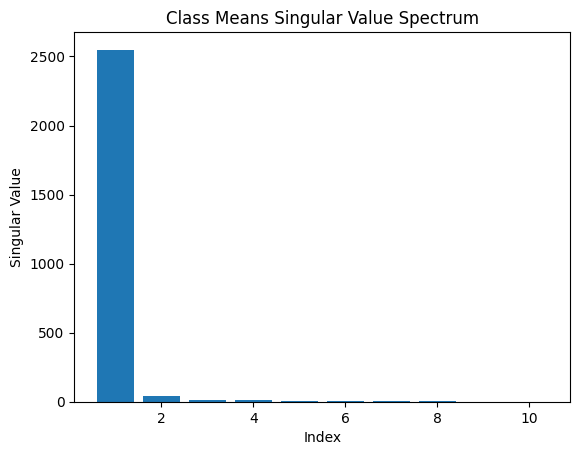

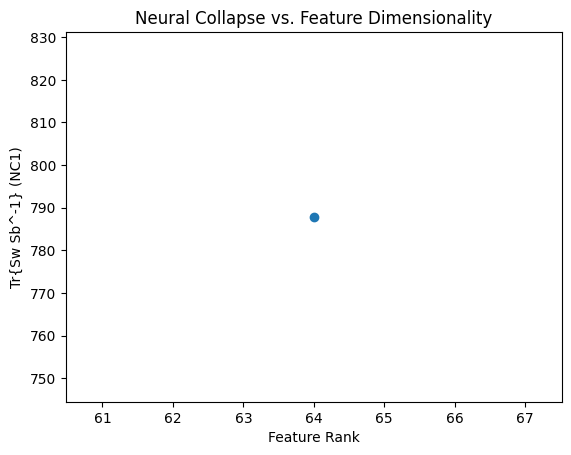

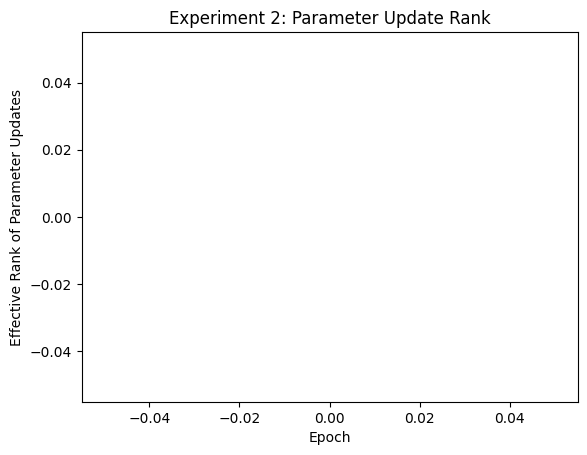

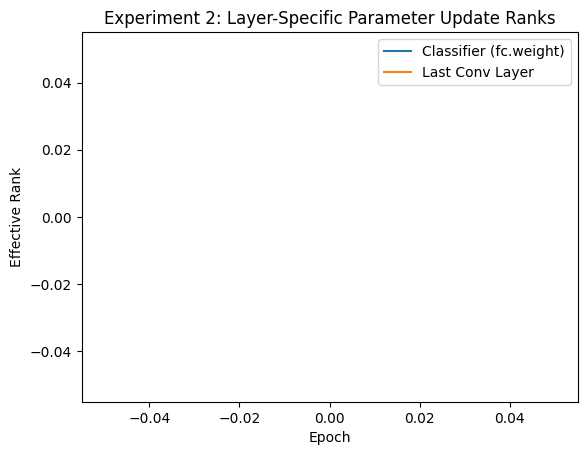

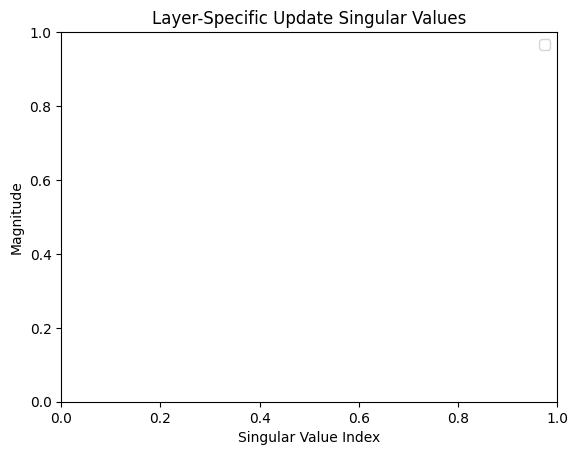

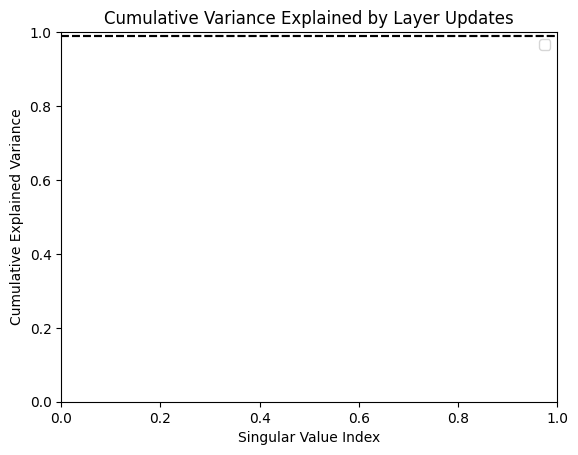

Checkpoint saved at epoch 1


Train		Epoch: 2 [21/390 (5%)] 	Batch Loss: 2.331970 	Batch Accuracy: 0.101562:   5%|▌         | 21/390 [03:57<1:09:26, 11.29s/it]
Analysis Metrics	Epoch: 2 [21/390 (5%)]:   5%|▌         | 21/390 [01:14<21:47,  3.54s/it]


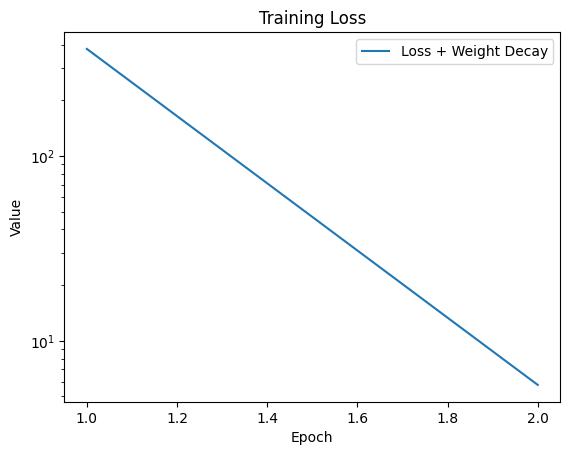

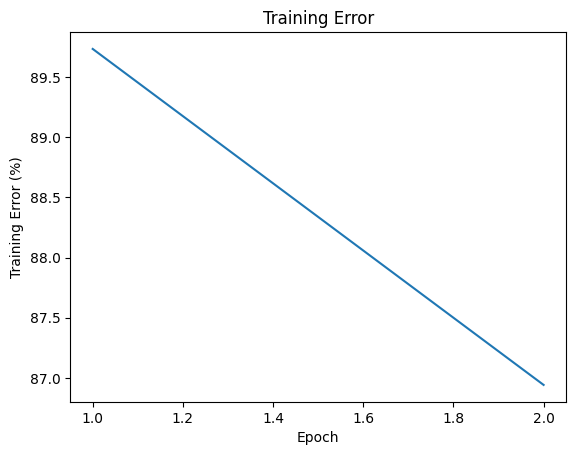

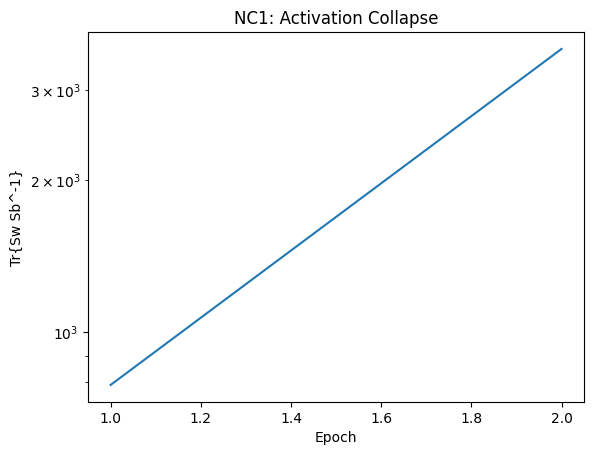

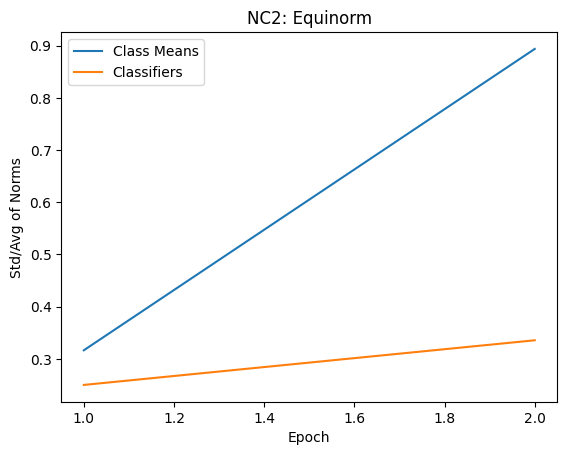

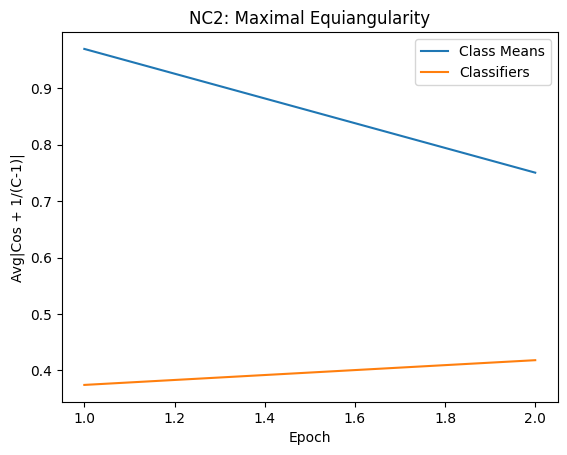

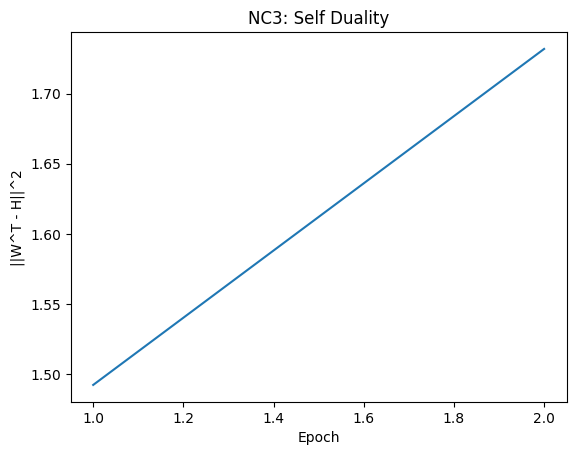

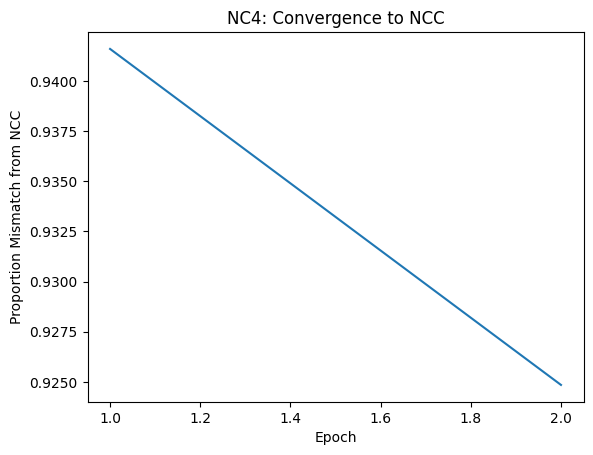

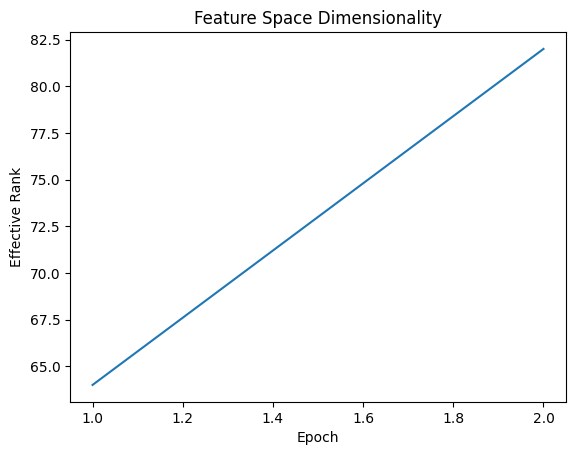

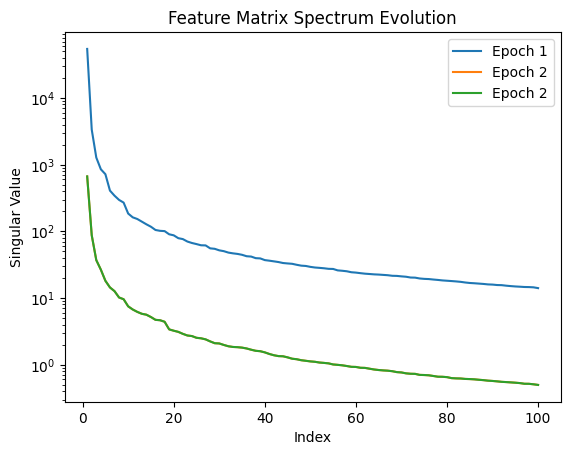

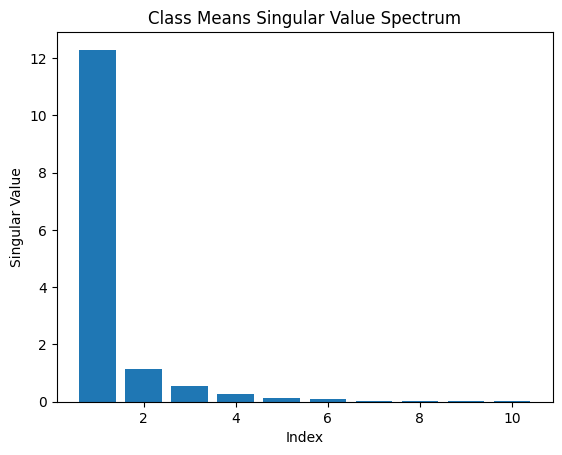

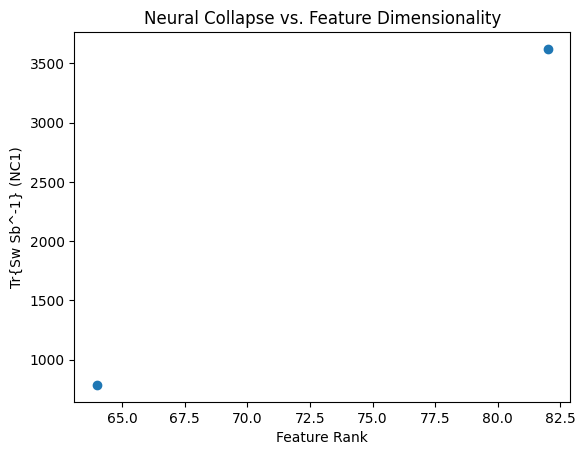

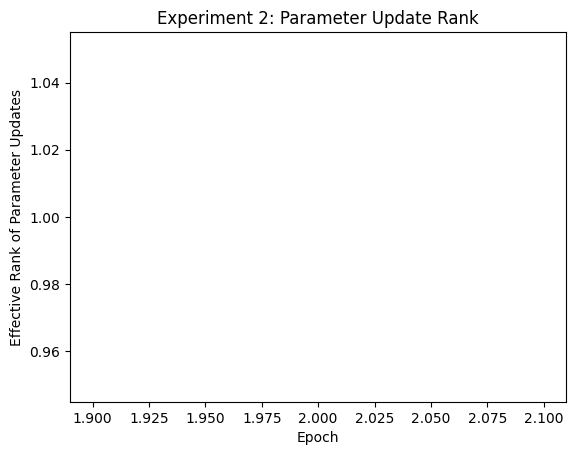

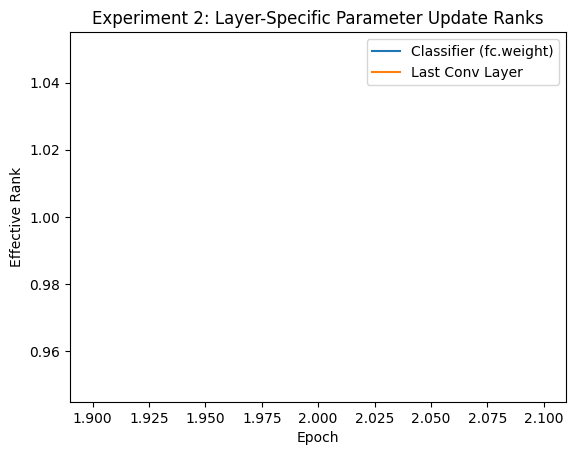

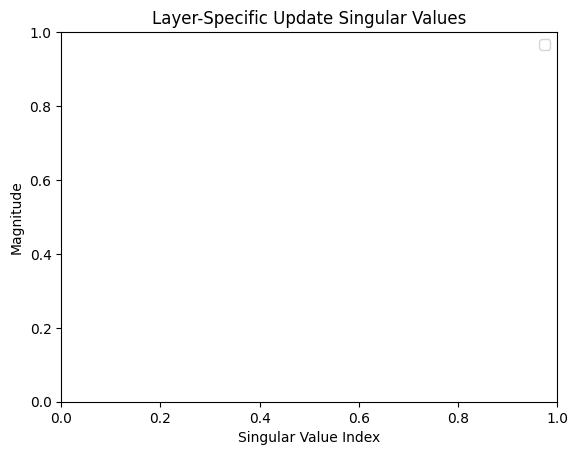

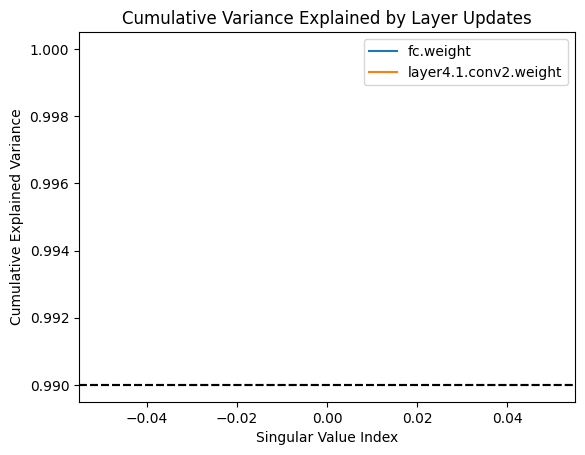

Checkpoint saved at epoch 2


Train		Epoch: 3 [21/390 (5%)] 	Batch Loss: 2.307213 	Batch Accuracy: 0.117188:   5%|▌         | 21/390 [03:56<1:09:13, 11.26s/it]
Train		Epoch: 4 [21/390 (5%)] 	Batch Loss: 2.066044 	Batch Accuracy: 0.203125:   5%|▌         | 21/390 [03:53<1:08:26, 11.13s/it]
Analysis Metrics	Epoch: 4 [21/390 (5%)]:   5%|▌         | 21/390 [01:13<21:26,  3.49s/it]


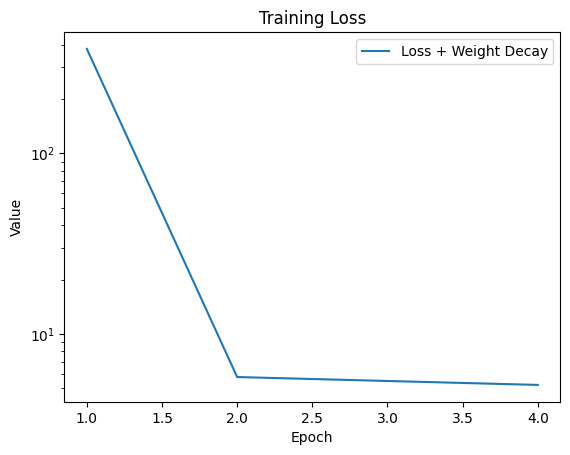

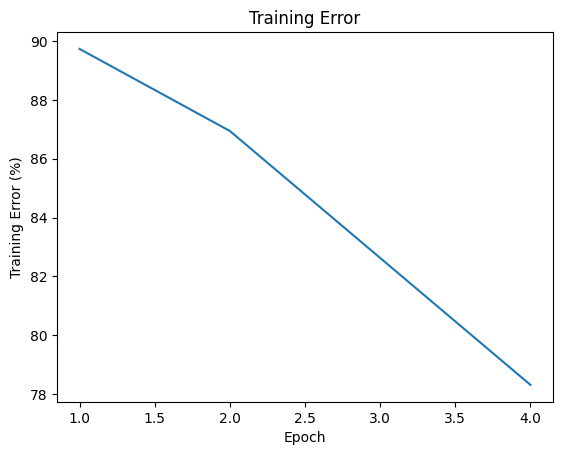

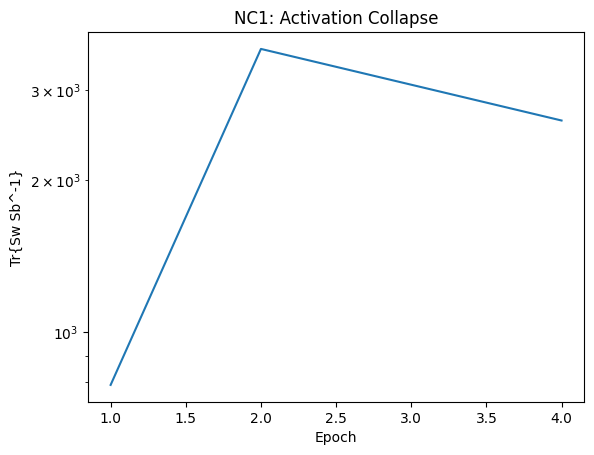

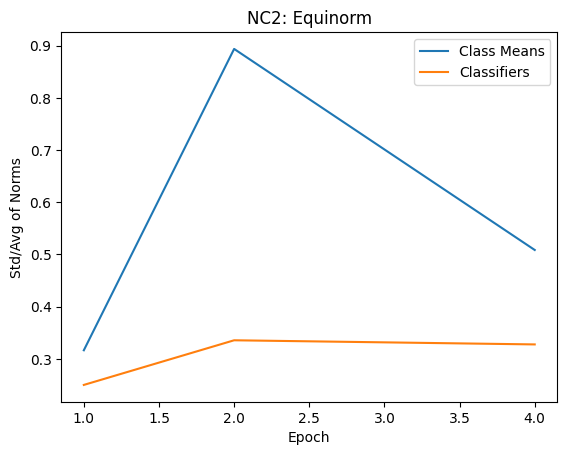

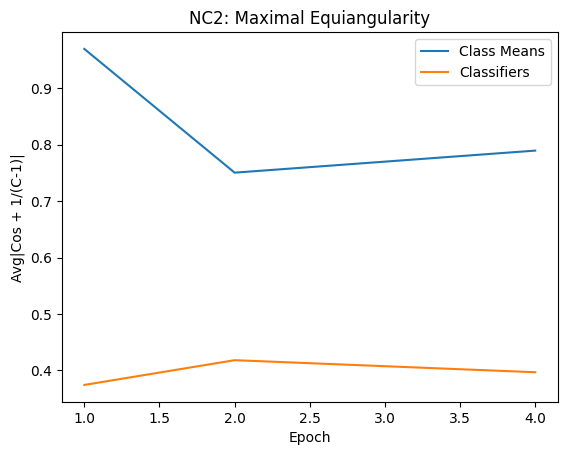

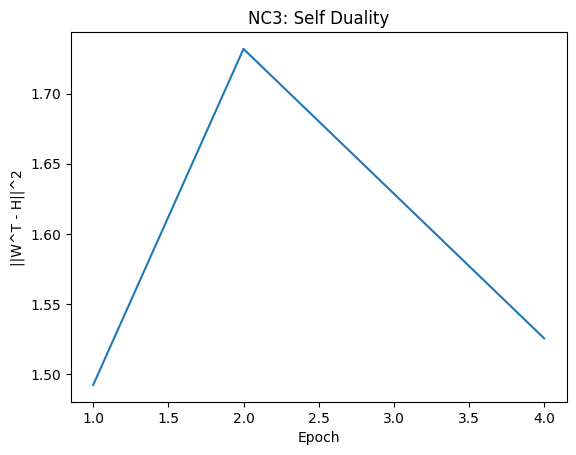

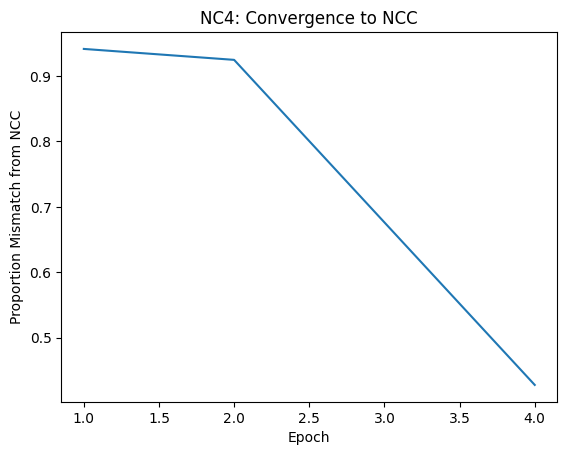

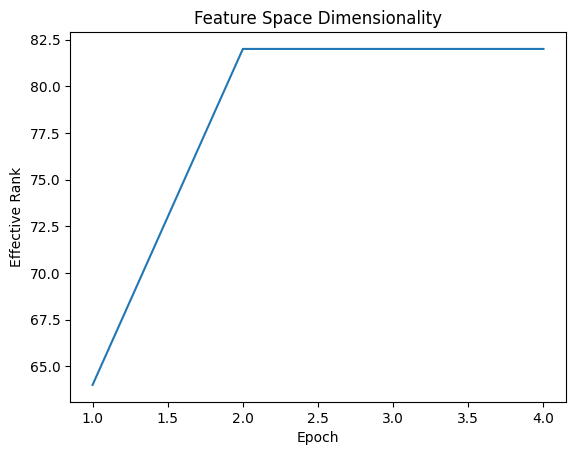

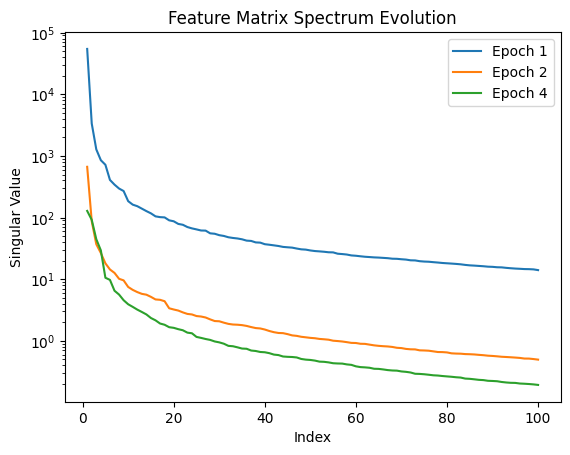

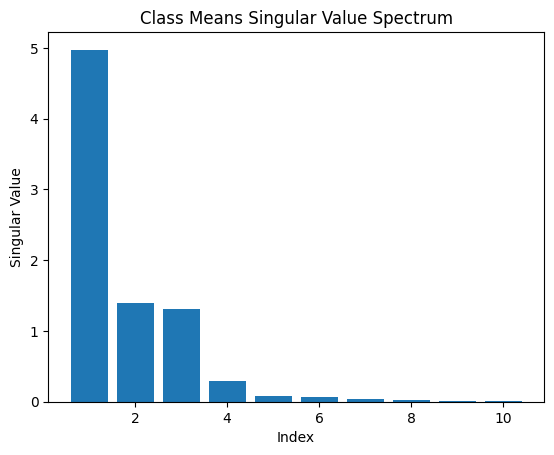

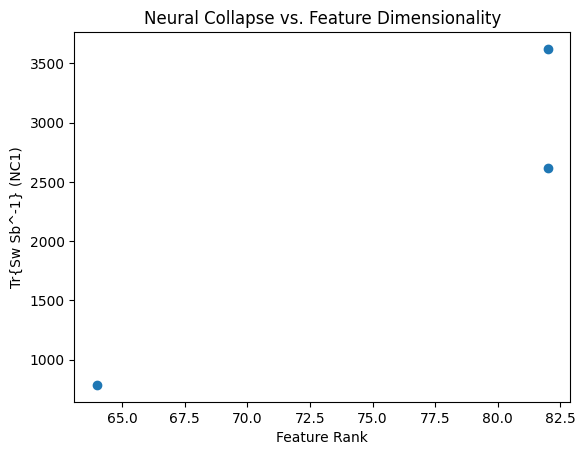

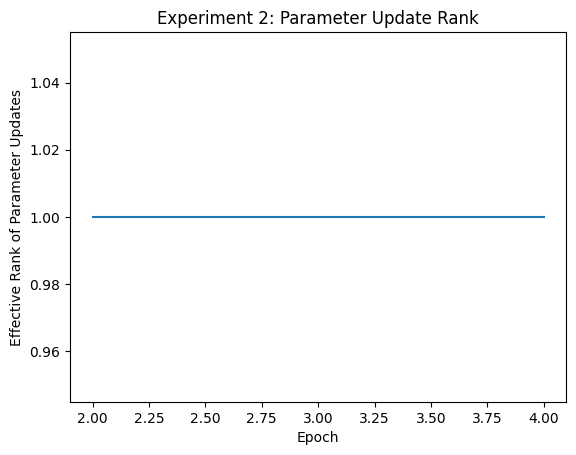

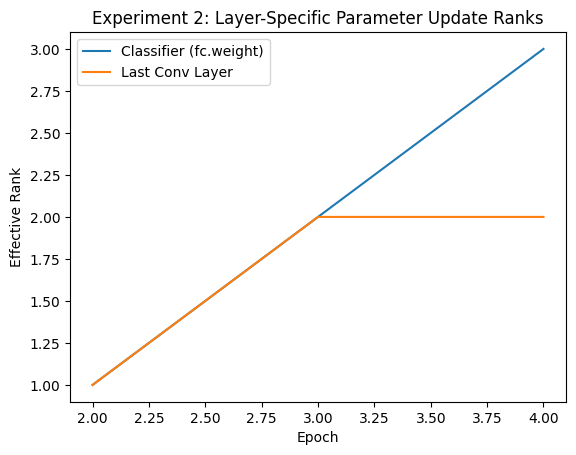

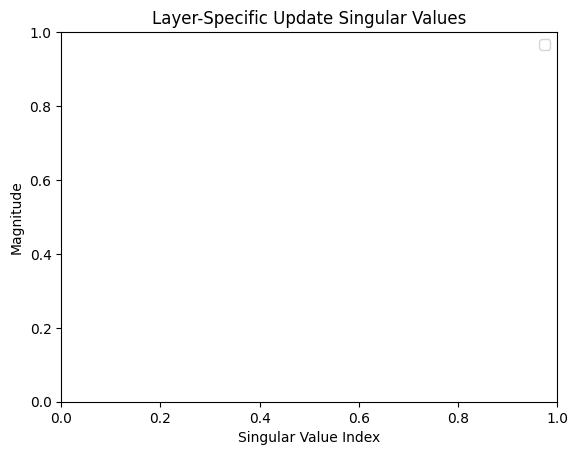

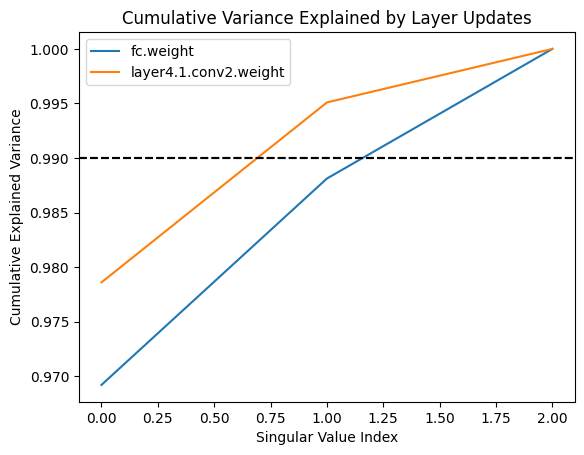

Checkpoint saved at epoch 4


Train		Epoch: 5 [21/390 (5%)] 	Batch Loss: 2.072282 	Batch Accuracy: 0.242188:   5%|▌         | 21/390 [03:58<1:09:46, 11.35s/it]
Analysis Metrics	Epoch: 5 [21/390 (5%)]:   5%|▌         | 21/390 [01:11<20:52,  3.39s/it]


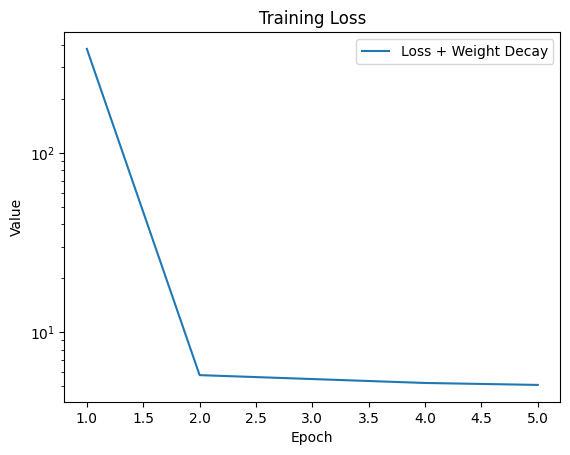

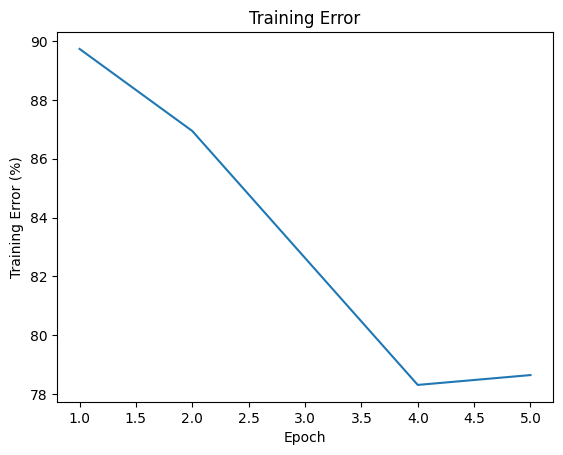

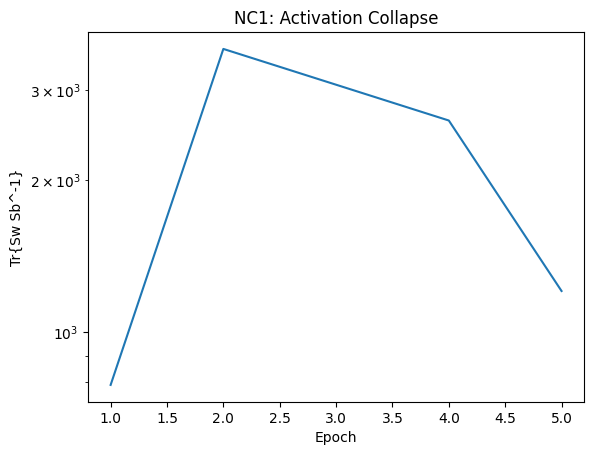

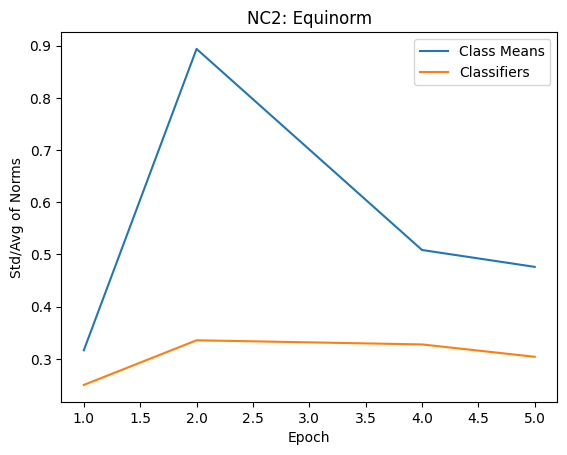

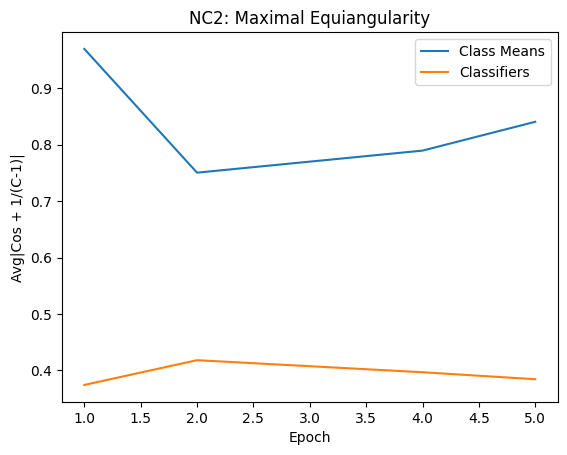

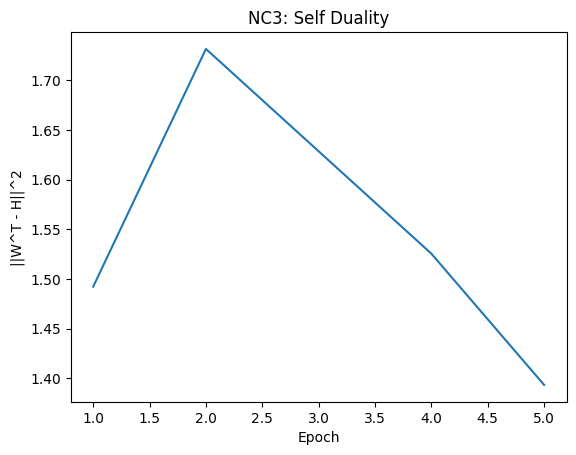

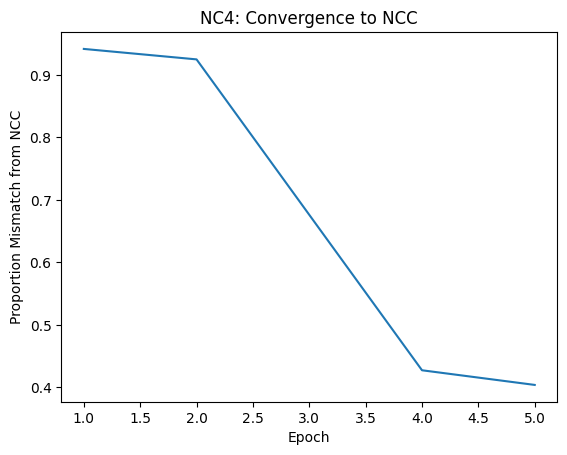

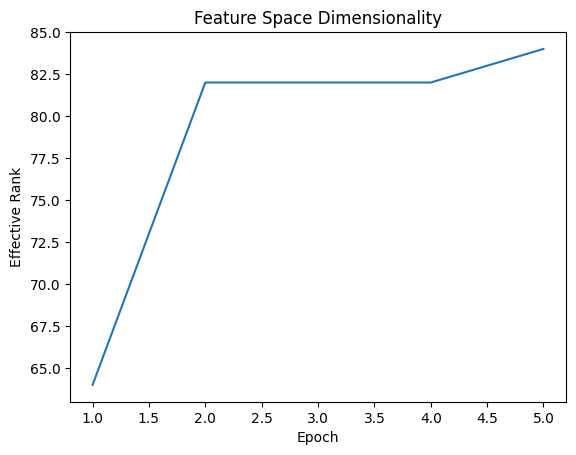

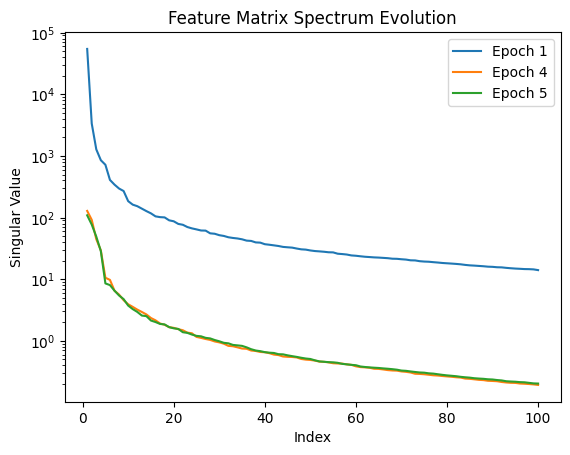

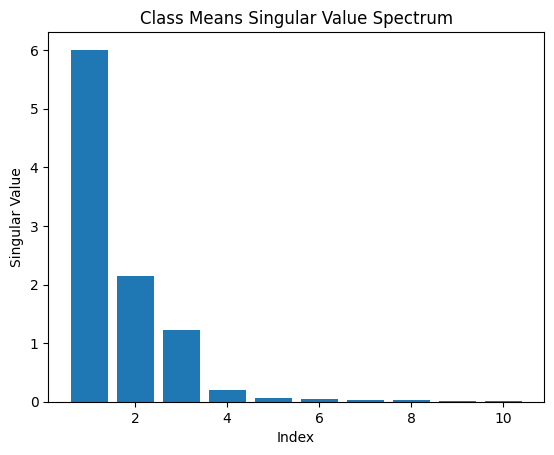

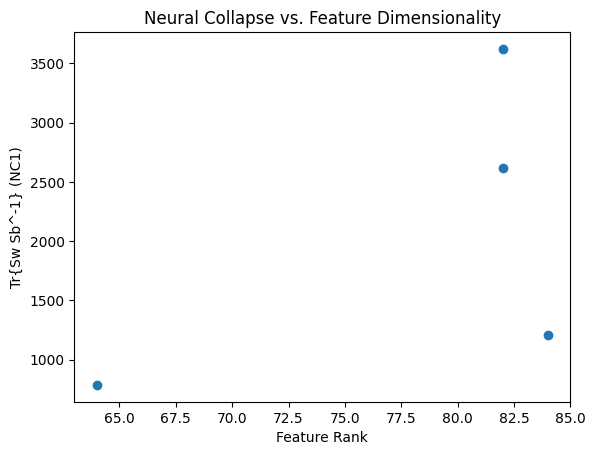

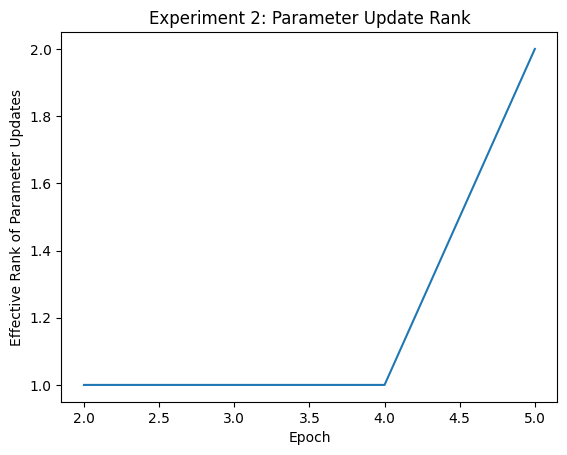

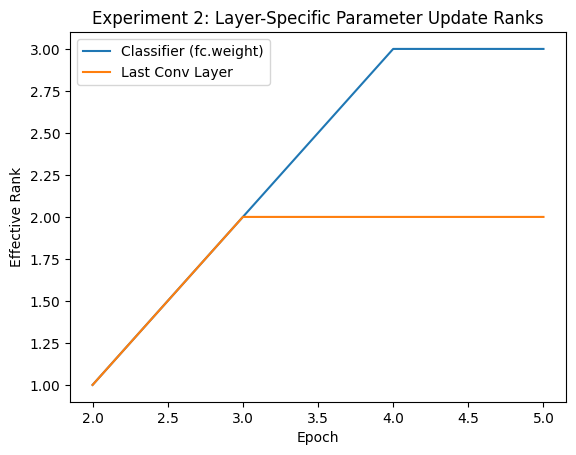

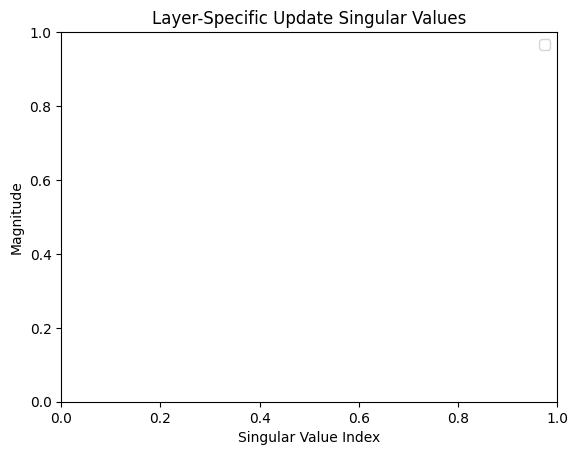

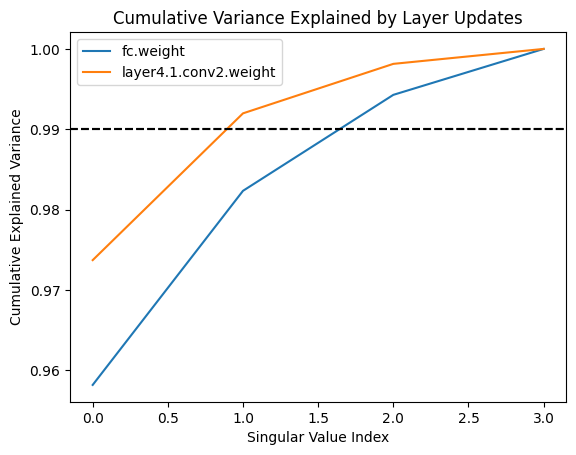

Checkpoint saved at epoch 5


Train		Epoch: 6 [21/390 (5%)] 	Batch Loss: 1.997272 	Batch Accuracy: 0.148438:   5%|▌         | 21/390 [03:55<1:09:00, 11.22s/it]
Analysis Metrics	Epoch: 6 [21/390 (5%)]:   5%|▌         | 21/390 [01:11<20:50,  3.39s/it]


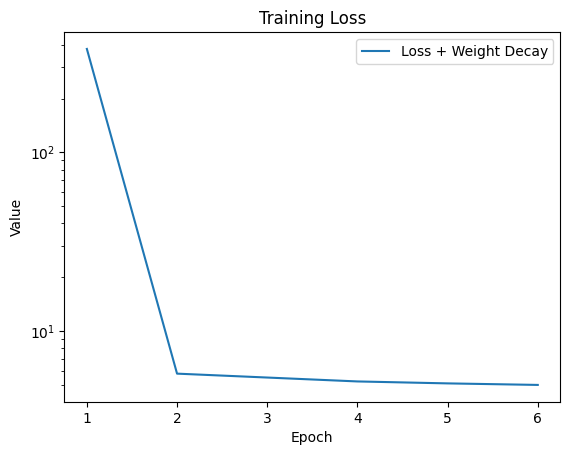

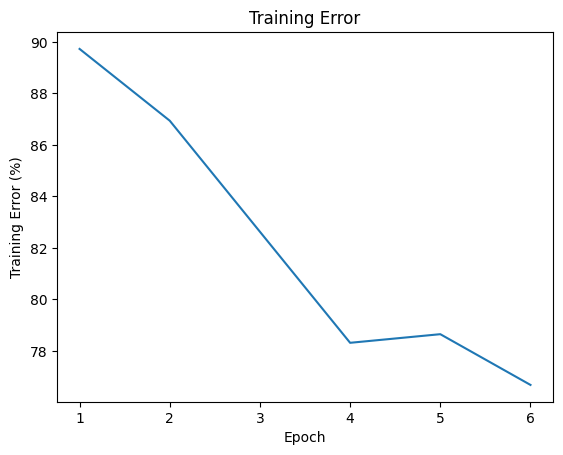

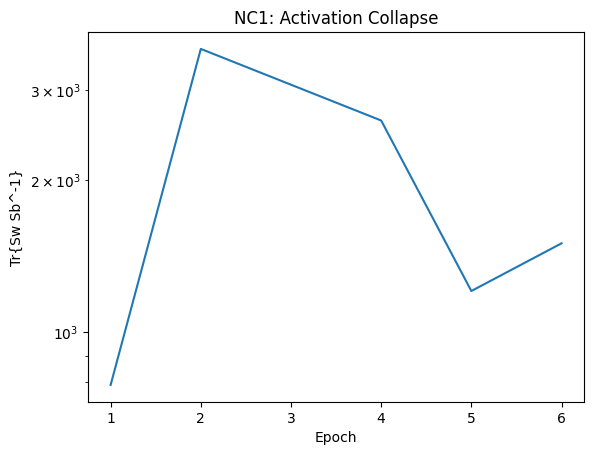

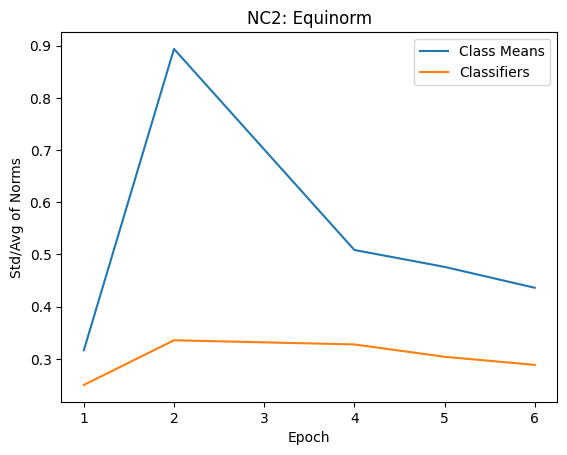

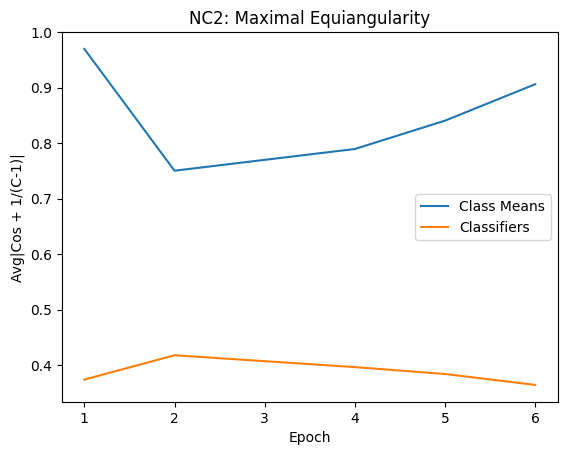

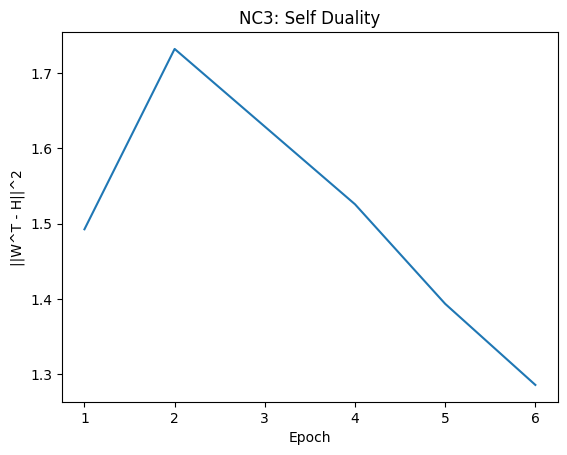

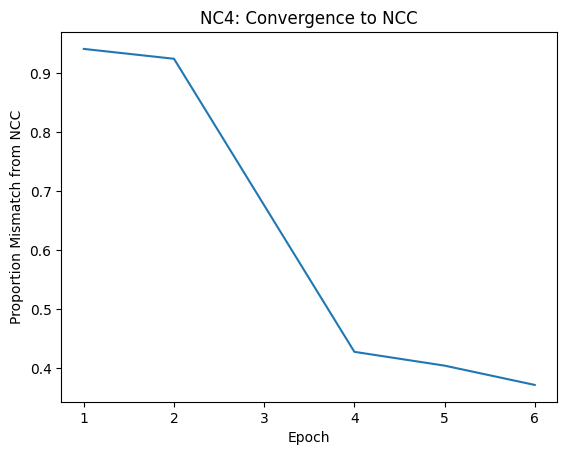

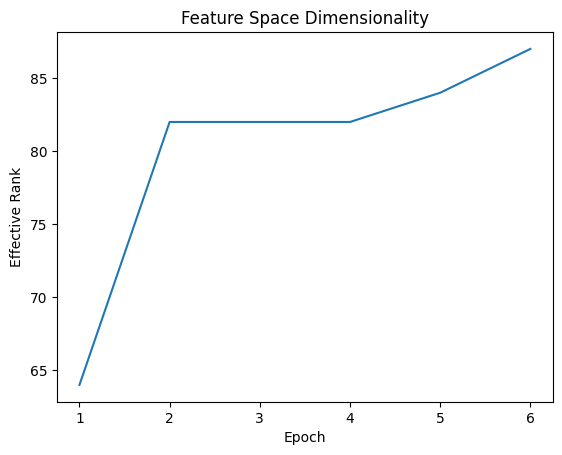

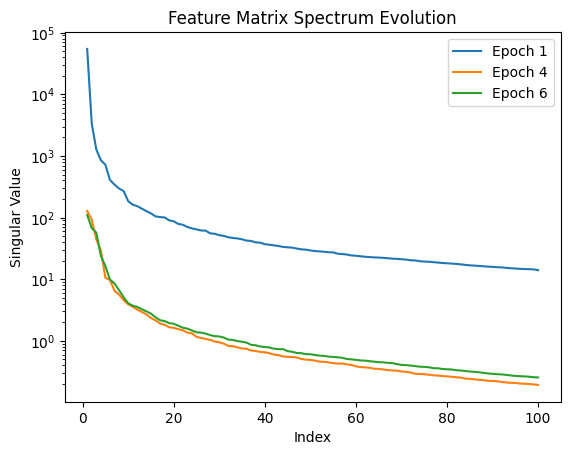

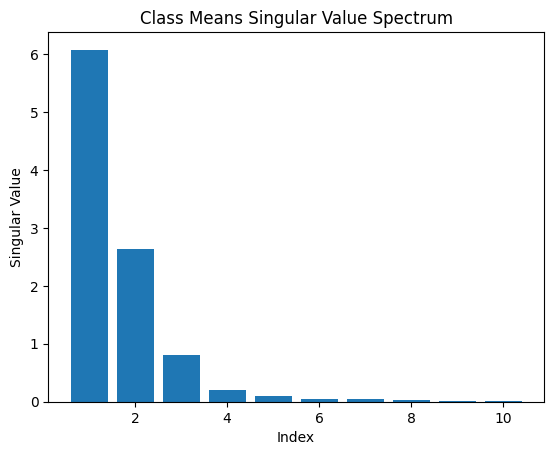

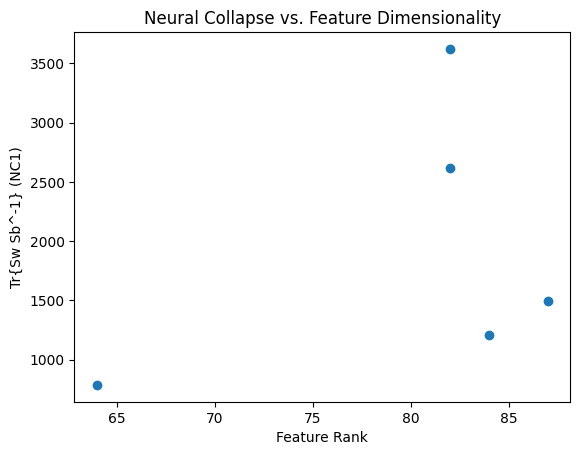

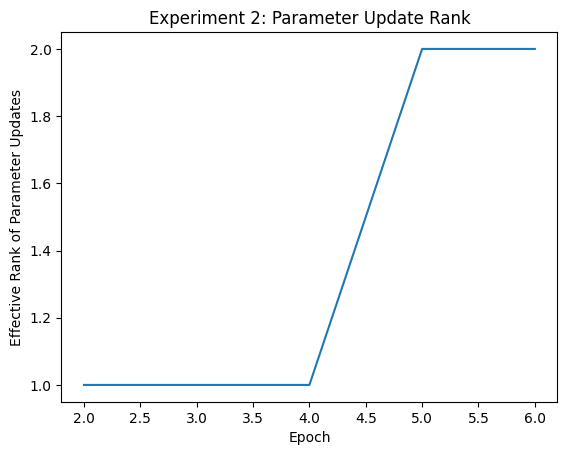

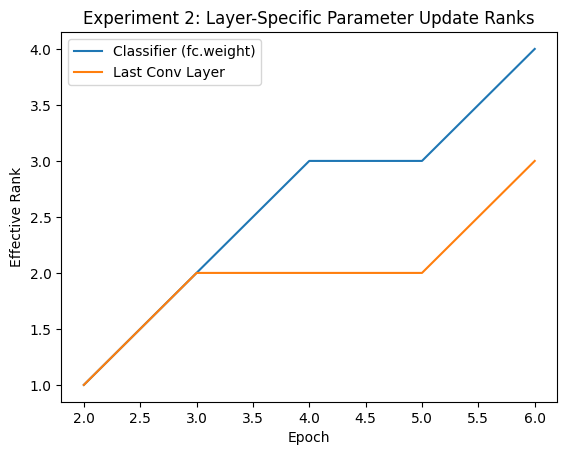

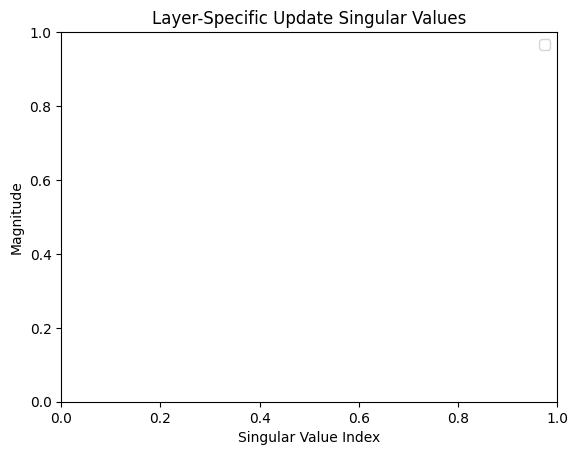

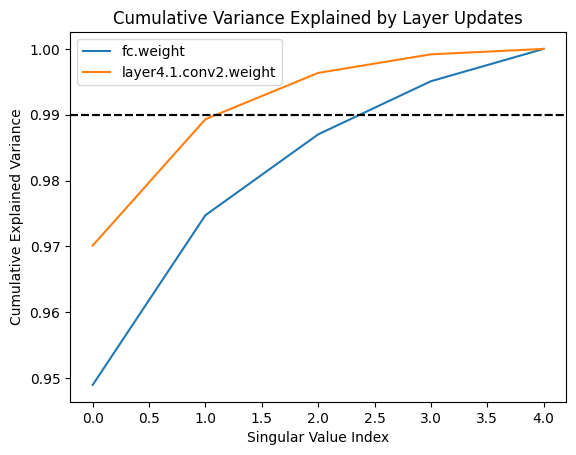

Checkpoint saved at epoch 6


Train		Epoch: 7 [15/390 (4%)] 	Batch Loss: 1.816813 	Batch Accuracy: 0.320312:   4%|▍         | 15/390 [03:01<1:14:03, 11.85s/it]

In [ ]:
model = models.resnet18(pretrained=False, num_classes=C)
model.conv1 = nn.Conv2d(input_ch, model.conv1.weight.shape[0], 3, 1, 1, bias=False) # Small dataset filter size used by He et al. (2015)
model.maxpool = nn.Identity()
model = model.to(device)

class features:
    pass

def hook(self, input, output):
    features.value = input[0].clone()

# register hook that saves last-layer input into features
classifier = model.fc
classifier.register_forward_hook(hook)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                ])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

analysis_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

if loss_name == 'CrossEntropyLoss':
  criterion = nn.CrossEntropyLoss()
  criterion_summed = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=epochs_lr_decay,
                                              gamma=lr_decay)
tracker = UpdateTracker(model)
graphs = Graphs()
cur_epochs = []
start_epoch = 1
checkpoint_path = '/content/drive/MyDrive/checkpoint.pth'

if not overwrite_checkpoint:
  try:
      checkpoint = torch.load(checkpoint_path, weights_only=False) # note: only use trusted source (checkpoint from MyDrive)
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
      start_epoch = checkpoint['epoch'] + 1
      graphs = checkpoint['graphs']
      cur_epochs = checkpoint['cur_epochs']
      print(f"Resuming from epoch {start_epoch}")
  except FileNotFoundError:
      print("No checkpoint found. Starting from scratch.")


for epoch in range(start_epoch, epochs + 1):
    train(model, criterion, device, C, train_loader, optimizer, epoch)
    lr_scheduler.step()

    # Compute update rank for every epoch
    if epoch > 1:
        effective_rank = tracker.compute_update_rank(model)
        graphs.update_ranks.append(effective_rank)
        graphs.update_spectra.append(tracker.singular_values[-1])

        # layer specific
        for layer_name in tracker.tracked_layers:
          if tracker.layer_effective_ranks[layer_name]:
              graphs.layer_update_ranks[layer_name].append(
                  tracker.layer_effective_ranks[layer_name][-1]
              )
          if tracker.layer_singular_values[layer_name]:
            graphs.layer_singular_values[layer_name].append(
                tracker.layer_singular_values[layer_name][-1]
            )

    if epoch in epoch_list:
        cur_epochs.append(epoch)
        analysis(graphs, model, criterion_summed, device, C, analysis_loader)

        ## NC Figures
        plt.figure(1)
        plt.semilogy(cur_epochs, graphs.reg_loss)
        plt.legend(['Loss + Weight Decay'])
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Training Loss')

        plt.figure(2)
        plt.plot(cur_epochs, 100*(1 - np.array(graphs.accuracy)))
        plt.xlabel('Epoch')
        plt.ylabel('Training Error (%)')
        plt.title('Training Error')

        plt.figure(3)
        plt.semilogy(cur_epochs, graphs.Sw_invSb)
        plt.xlabel('Epoch')
        plt.ylabel('Tr{Sw Sb^-1}')
        plt.title('NC1: Activation Collapse')

        plt.figure(4)
        plt.plot(cur_epochs, graphs.norm_M_CoV)
        plt.plot(cur_epochs, graphs.norm_W_CoV)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Std/Avg of Norms')
        plt.title('NC2: Equinorm')

        plt.figure(5)
        plt.plot(cur_epochs, graphs.cos_M)
        plt.plot(cur_epochs, graphs.cos_W)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Avg|Cos + 1/(C-1)|')
        plt.title('NC2: Maximal Equiangularity')

        plt.figure(6)
        plt.plot(cur_epochs,graphs.W_M_dist)
        plt.xlabel('Epoch')
        plt.ylabel('||W^T - H||^2')
        plt.title('NC3: Self Duality')

        plt.figure(7)
        plt.plot(cur_epochs,graphs.NCC_mismatch)
        plt.xlabel('Epoch')
        plt.ylabel('Proportion Mismatch from NCC')
        plt.title('NC4: Convergence to NCC')

        ## Experiment 1 Figures
        plt.figure(8)
        plt.plot(cur_epochs, graphs.feature_rank)
        plt.xlabel('Epoch')
        plt.ylabel('Effective Rank')
        plt.title('Feature Space Dimensionality')

        plt.figure(9)
        # Plot singular value spectra for selected epochs
        selected_epochs = [0, len(cur_epochs)//2, -1]  # First, middle, last
        for i, epoch_idx in enumerate(selected_epochs):
            if epoch_idx < len(graphs.singular_values):
                sv = graphs.singular_values[epoch_idx]
                plt.semilogy(range(1, len(sv)+1), sv, label=f'Epoch {cur_epochs[epoch_idx]}')
        plt.xlabel('Index')
        plt.ylabel('Singular Value')
        plt.title('Feature Matrix Spectrum Evolution')
        plt.legend()

        plt.figure(10)
        # Plot class means singular values for the last epoch
        if len(graphs.mean_singular_values) > 0:
            sv_means = graphs.mean_singular_values[-1]
            plt.bar(range(1, len(sv_means)+1), sv_means)
            plt.xlabel('Index')
            plt.ylabel('Singular Value')
            plt.title('Class Means Singular Value Spectrum')

        # Correlation between NC metrics and feature rank
        plt.figure(11)
        plt.scatter(graphs.feature_rank, graphs.Sw_invSb)
        plt.xlabel('Feature Rank')
        plt.ylabel('Tr{Sw Sb^-1} (NC1)')
        plt.title('Neural Collapse vs. Feature Dimensionality')

        ## Experiment 2 Figures
        # Update rank
        update_epochs = list(range(2, epoch + 1))
        plt.figure(12)
        plt.plot(update_epochs, graphs.update_ranks)
        plt.xlabel('Epoch')
        plt.ylabel('Effective Rank of Parameter Updates')
        plt.title('Experiment 2: Parameter Update Rank')

        # Layer-Specific Update Ranks
        plt.figure(13)
        plt.plot(update_epochs, graphs.layer_update_ranks['fc.weight'], label='Classifier (fc.weight)')
        plt.plot(update_epochs, graphs.layer_update_ranks['layer4.1.conv2.weight'], label='Last Conv Layer')
        plt.xlabel('Epoch')
        plt.ylabel('Effective Rank')
        plt.legend()
        plt.title('Layer-Specific Parameter Update Ranks')

        plt.figure(14)
        for layer_name in tracked_layers:
            # Plot spectra at epoch 110, 225, 350 only [must be in epoch_list]
            for epoch_idx in [110, 225, 350]:
                if epoch_idx < len(graphs.layer_singular_values[layer_name]):
                    sv = graphs.layer_singular_values[layer_name][epoch_idx]
                    plt.semilogy(range(1, len(sv)+1), sv,
                            label=f'{layer_name} (Epoch {epoch_idx})')
        plt.xlabel('Singular Value Index')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.title('Layer-Specific Update Singular Values')

        plt.figure(15)
        for layer_name in tracked_layers:
          if len(graphs.layer_singular_values[layer_name]) > 0:
              sv = graphs.layer_singular_values[layer_name][-1]  # Last epoch
              explained_variance = np.cumsum(sv**2) / np.sum(sv**2)
              plt.plot(explained_variance, label=layer_name)
          plt.axhline(RANK_THRESHOLD, color='k', linestyle='--')
          plt.xlabel('Singular Value Index')
          plt.ylabel('Cumulative Explained Variance')
          plt.legend()
          plt.title('Cumulative Variance Explained by Layer Updates')

        plt.show()

        # save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'graphs': graphs,
            # 'tracker': tracker, #this will be a LOT of data later...
            'cur_epochs': cur_epochs
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

## Storing data for analysis

In [ ]:
# Save metrics to CSV
df = pd.DataFrame({
    'epoch': cur_epochs,
    'Sw_invSb': graphs.Sw_invSb,
    'feature_rank': graphs.feature_rank,
    'W_M_dist': graphs.W_M_dist,
    'NCC_mismatch': graphs.NCC_mismatch,
    'norm_M_CoV': graphs.norm_M_CoV,
    'norm_W_CoV': graphs.norm_W_CoV,
    'cos_M': graphs.cos_M,
    'cos_W': graphs.cos_W,
    'update_ranks': graphs.update_ranks
})
df.to_csv('nc_metrics.csv', index=False)

# Save singular values (numpy arrays)
np.save('feature_svs.npy', graphs.singular_values)
np.save('mean_svs.npy', graphs.mean_singular_values)
np.save('update_spectra.npy', graphs.update_spectra)

# Save figures
figures_to_save = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]  # All
for fig_num in figures_to_save:
    plt.figure(fig_num)
    plt.savefig(f'figure_{fig_num}_epoch_{epoch}.pdf', bbox_inches='tight', dpi=300)
    plt.close()